In [1]:
from google.colab import drive

drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/CremaD'
model_path = '/content/drive/MyDrive/4_1/aisys/승권_aisys/wav2vec'

Mounted at /content/drive


In [2]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader



import os
import pandas as pd
import numpy as np
import librosa
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import Wav2Vec2FeatureExtractor, AutoModelForAudioClassification, Wav2Vec2Processor, set_seed

from audiomentations import Compose, AddGaussianNoise, PitchShift, Shift, HighPassFilter, LowPassFilter, HighShelfFilter, LowShelfFilter

In [4]:
print(torch.__version__)
print(np.__version__)

2.3.0+cu121
1.25.2


In [5]:
def seed_everything(seed):
  torch.random.manual_seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  set_seed(seed)
  np.random.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed_everything(42)

# Prepare Train Dataset

In [6]:
train_list = pd.read_csv(os.path.join(data_path, 'train.csv'))
train_list.head(5)

,id,path,label
0,TRAIN_0000,/content/drive/My Drive/CremaD/train/TRAIN_000...,5
1,TRAIN_0001,/content/drive/My Drive/CremaD/train/TRAIN_000...,2
2,TRAIN_0002,/content/drive/My Drive/CremaD/train/TRAIN_000...,0
3,TRAIN_0003,/content/drive/My Drive/CremaD/train/TRAIN_000...,5
4,TRAIN_0004,/content/drive/My Drive/CremaD/train/TRAIN_000...,1


In [7]:
train_datas = list(train_list['path'])
train_labels = list(train_list['label'])

train_datas, val_datas, train_labels, val_labels = train_test_split(train_datas, train_labels, test_size = 0.25, shuffle = True, random_state = 42)

# Train Model

https://huggingface.co/ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition

In [8]:
# Model 로드
feature_ex = Wav2Vec2FeatureExtractor.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
model = AutoModelForAudioClassification.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.bias', 'classifier.output.weight', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-e

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=

In [9]:
data_path

'/content/drive/MyDrive/CremaD'

In [10]:
class CustomDataset(Dataset):
    def __init__(self, data, label, feature_ex, augment=None):
        self.data = data
        self.labels = label
        self.feature_ex = feature_ex
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features, _ = librosa.load(os.path.join(data_path, self.data[idx]), sr=16000)
        if self.augment:
          features = self.augment(samples=features, sample_rate=16000)
        features = self.feature_ex(features, sampling_rate = 16000, return_tensors = "pt", padding = True).input_values
        features = features.squeeze()
        label = self.labels[idx]
        return features, label

In [11]:
#Padding 함수
def collate_fn(batch):
    datas, labels = zip(*batch)
    datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
    labels = pad_sequence([torch.tensor([label]) for label in labels], batch_first=True, padding_value=0)
    return datas, labels

In [12]:
num_classes = 6
batch_size = 32
lr = 2e-5
num_epochs = 5

In [13]:
augment = Compose([
    AddGaussianNoise(p=0.1),
    #PitchShift(p=0.1),
    Shift(p=0.1),
    #HighPassFilter(p=0.1),
    #LowPassFilter(p=0.1),
    #HighShelfFilter(p=0.1),
    #LowShelfFilter(p=0.1)
])

In [14]:
# Train Dataset 로드
train_dataset = CustomDataset(train_datas, train_labels, feature_ex, augment)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=3, collate_fn=collate_fn)

# Validation Dataset 로드
val_dataset = CustomDataset(val_datas, val_labels, feature_ex)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3, collate_fn=collate_fn)

In [15]:
# 기존 모델 : 8개의 label로 emotion classification
# 현재 task : 6개의 label로 emotion classification
class EmotionClassifier_Align(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs):
      # CREMA-D 0: angry 1: fear 2: sad 3: disgust 4: neutral 5: happy
      # wav2vec2 pretrained ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
      # 0, 3, 6, 2, 5, 4
        inputs = inputs.cuda()
        outputs = self.model(inputs)
        mask = torch.tensor([0, 3, 6, 2, 5, 4])
        outputs.logits = outputs.logits[:, mask]
        return outputs.logits

class FocalLoss(nn.Module):
  def __init__(self, alpha=1, gamma=2):
      super(FocalLoss, self).__init__()
      self.alpha = alpha
      self.gamma = gamma

  def forward(self, inputs, targets):
      BCE_loss = nn.CrossEntropyLoss()(inputs, targets)
      pt = torch.exp(-BCE_loss)
      F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
      return F_loss

In [16]:
n_layers = model.config.num_hidden_layers
llrd_params = []
lr = 2e-5
weight_decay = 0.00
layer_decay = 1

for name, param in model.named_parameters():
    if 'bias' in name or 'layer_norm' in name:
        llrd_params.append({'params': param, 'lr': lr, 'weight_decay': 0.0})
    elif 'feature_extractor' in name:
        llrd_params.append({'params': param, 'lr': lr * (layer_decay**1), 'weight_decay': weight_decay})
    elif 'feature_projection' in name:
        llrd_params.append({'params': param, 'lr': lr * (layer_decay**2), 'weight_decay': weight_decay})
    elif 'encoder.pos_conv_embed' in name:
        llrd_params.append({'params': param, 'lr': lr * (layer_decay**3), 'weight_decay': weight_decay})
    elif 'encoder.layers' in name:
        layer_idx = int(name.split('.')[3])
        llrd_params.append({'params': param, 'lr': lr * (layer_decay**(layer_idx + 4)), 'weight_decay': weight_decay})
    elif 'projector' in name or 'classifier' in name:
        llrd_params.append({'params': param, 'lr': lr, 'weight_decay': weight_decay})
    else:
        llrd_params.append({'params': param, 'lr': lr, 'weight_decay': weight_decay})

In [17]:
n_init_layers = 0

if n_init_layers>0:
  model.classifier.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
  model.classifier.bias.data.zero_()
if n_init_layers>1:
  model.projector.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
  model.projector.bias.data.zero_()
if n_init_layers>2:
  model.wav2vec2.encoder.layers[0].final_layer_norm.weight.data.fill_(1.0)
if n_init_layers>3:
  model.wav2vec2.encoder.layers[0].feed_forward.output_dense.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
  model.wav2vec2.encoder.layers[0].feed_forward.output_dense.bias.data.zero_()
if n_init_layers>4:
  model.wav2vec2.encoder.layers[0].feed_forward.intermediate_dense.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
  model.wav2vec2.encoder.layers[0].feed_forward.intermediate_dense.bias.data.zero_()
if n_init_layers>5:
  model.wav2vec2.encoder.layers[0].layer_norm.weight.data.fill_(1.0)

In [18]:
emotion_model = EmotionClassifier_Align(model).cuda()
criterion = nn.CrossEntropyLoss()
#criterion = FocalLoss()

#optimizer = optim.Adam(llrd_params)
optimizer = optim.AdamW(llrd_params)

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=140)

In [19]:
emotion_model

EmotionClassifier_Align(
  (model): Wav2Vec2ForSequenceClassification(
    (wav2vec2): Wav2Vec2Model(
      (feature_extractor): Wav2Vec2FeatureEncoder(
        (conv_layers): ModuleList(
          (0): Wav2Vec2LayerNormConvLayer(
            (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
            (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (activation): GELUActivation()
          )
          (1-4): 4 x Wav2Vec2LayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
            (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (activation): GELUActivation()
          )
          (5-6): 2 x Wav2Vec2LayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
            (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (activation): GELUActivation()
          )
        )
      )
      (feature_projection): Wav2Vec2FeaturePr

In [20]:
# Training Loop

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    emotion_model.train()
    train_loss = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.cuda(), labels.squeeze().cuda()
        optimizer.zero_grad()
        outputs = emotion_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)  # 배치 크기로 가중 평균
    train_loss /= len(train_loader.dataset)  # 전체 데이터셋 크기로 나눔
    train_losses.append(train_loss)

    # Validation
    emotion_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.cuda(), labels.squeeze().cuda()
            outputs = emotion_model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item() * inputs.size(0)  # 배치 크기로 가중 평균
        val_loss /= len(val_loader.dataset)  # 전체 데이터셋 크기로 나눔
        val_losses.append(val_loss)

    val_accuracy = correct / total
    print(f"\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}")
    #77.9

Epoch 1/5 - Training:   0%|          | 0/140 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: T


Epoch 1/5, Train Loss: 1.3480, Validation Loss: 1.0233, Validation Accuracy: 65.21%


Epoch 2/5 - Training:   0%|          | 0/140 [00:00<?, ?it/s]<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for dat


Epoch 2/5, Train Loss: 0.9307, Validation Loss: 0.8137, Validation Accuracy: 72.13%


Epoch 3/5 - Training:   0%|          | 0/140 [00:00<?, ?it/s]<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for dat


Epoch 3/5, Train Loss: 0.8131, Validation Loss: 0.7480, Validation Accuracy: 73.40%


Epoch 4/5 - Training:   0%|          | 0/140 [00:00<?, ?it/s]<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for dat


Epoch 4/5, Train Loss: 0.6984, Validation Loss: 0.6983, Validation Accuracy: 75.35%


Epoch 5/5 - Training:   0%|          | 0/140 [00:00<?, ?it/s]<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for dat


Epoch 5/5, Train Loss: 0.6093, Validation Loss: 0.6495, Validation Accuracy: 77.37%


In [23]:
# Training Loop

for epoch in range(1):
    emotion_model.train()
    train_loss = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {6}/{6} - Training"):

        inputs, labels = inputs.cuda(), labels.squeeze().cuda()
        optimizer.zero_grad()
        outputs = emotion_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)  # 배치 크기로 가중 평균
    train_loss /= len(train_loader.dataset)  # 전체 데이터셋 크기로 나눔
    train_losses.append(train_loss)

    # Validation
    emotion_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {6}/{6} - Validation"):
            inputs, labels = inputs.cuda(), labels.squeeze().cuda()
            outputs = emotion_model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item() * inputs.size(0)  # 배치 크기로 가중 평균
        val_loss /= len(val_loader.dataset)  # 전체 데이터셋 크기로 나눔
        val_losses.append(val_loss)

    val_accuracy = correct / total
    print(f"\nEpoch {6}/{6}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}")

Epoch 6/6 - Training:   0%|          | 0/140 [00:00<?, ?it/s]<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
<ipython-input-11-c93b8d1e54cb>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for dat


Epoch 6/6, Train Loss: 0.5551, Validation Loss: 0.6399, Validation Accuracy: 78.11%


In [63]:
train_losses, val_losses

([1.3351597696222284,
  0.9072479357856149,
  0.7728918694680736,
  0.6799454231843299,
  0.5662845280221713],
 [1.0213700073769303,
  0.8278678294553943,
  0.7319220513845948,
  0.6656638725721412,
  0.6454135940889931])

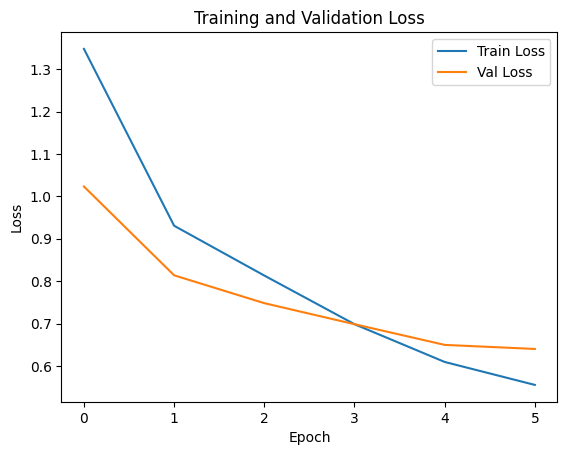

In [25]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

In [26]:
# Model 저장
torch.save(emotion_model.state_dict(), os.path.join(model_path, "Emotion_Recog_Model_FINAL_.pth"))

# Prepare Test Dataset

In [27]:
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import Wav2Vec2FeatureExtractor, AutoModelForAudioClassification
from transformers import Wav2Vec2Processor

from google.colab import drive

drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/CremaD'
model_path = '/content/drive/MyDrive/4_1/aisys/승권_aisys/wav2vec'


num_classes = 6
batch_size = 32
lr = 2e-5
num_epochs = 5

test_list = pd.read_csv(os.path.join(data_path, 'test.csv'))
test_list['path'] = test_list['path']

test_datas = list(test_list['path'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Custom Dataset 함수 Define

class CustomDatasetForTest(Dataset):
    def __init__(self, data, feature_ex):
        self.data = data
        self.feature_ex = feature_ex

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features, _ = librosa.load(os.path.join(data_path, self.data[idx]), sr=16000)
        features = self.feature_ex(features, sampling_rate = 16000, return_tensors = "pt", padding = True).input_values
        features = features.squeeze()
        return features

In [29]:
# Padding 함수 Define

def collate_fn_test(batch):
    datas = pad_sequence([torch.tensor(data) for data in batch], batch_first=True, padding_value=0)  # pad the sequences
    return datas

# Predict with Trained Model

In [30]:
# Model Output Layer 수정
# 기존 모델 : 8개의 label로 emotion classification
# 현재 task : 6개의 label로 emotion classification

class EmotionClassifier_Add(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.classifier = torch.nn.Identity()
        self.classifier = nn.Linear(in_features=256, out_features=num_classes)

    def forward(self, inputs):
        inputs = inputs.cuda()
        outputs = self.model(inputs)
        outputs = self.classifier(outputs.logits)
        return outputs
    #(projector): Linear(in_features=1024, out_features=256, bias=True)
    # original classifier -> Identity로 교체
    #(classifier): Linear(in_features=256, out_features=6, bias=True)

class EmotionClassifier_Replace(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.classifier = nn.Linear(in_features=256, out_features=num_classes)

    def forward(self, inputs):
        inputs = inputs.cuda()
        outputs = self.model(inputs)
        return outputs.logits


class EmotionClassifier_Align(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs):
      # CREMA-D 0: angry 1: fear 2: sad 3: disgust 4: neutral 5: happy
      # wav2vec pretrained ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
      # 0, 3, 6, 2, 5, 4
        inputs = inputs.cuda()
        outputs = self.model(inputs)
        mask = torch.tensor([0, 3, 6, 2, 5, 4])
        outputs.logits = outputs.logits[:, mask]
        return outputs.logits

from torch.nn.utils.rnn import pad_sequence

# Padding 함수 Define

def collate_fn(batch):
    datas, labels = zip(*batch)
    datas = pad_sequence([torch.tensor(data) for data in datas], batch_first=True, padding_value=0)
    labels = pad_sequence([torch.tensor([label]) for label in labels], batch_first=True, padding_value=0)
    return datas, labels

In [46]:
# Model 로드
feature_ex = Wav2Vec2FeatureExtractor.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
model = AutoModelForAudioClassification.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")
model.cuda()

model_test = EmotionClassifier_Align(model)
#model_test.load_state_dict(torch.load(os.path.join(model_path, "Emotion_Recog_Model_AddNoise.pth")))
#model_test.load_state_dict(torch.load(os.path.join(model_path, "Emotion_Recog_Model_base.pth")))
#model_test.load_state_dict(torch.load(os.path.join(model_path, "Emotion_Recog_Model_FINAL.pth")))
model_test.load_state_dict(torch.load(os.path.join(model_path, "Emotion_Recog_Model_FINAL_.pth")))
model_test.cuda()

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.output.bias', 'classifier.output.weight', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mod

EmotionClassifier_Align(
  (model): Wav2Vec2ForSequenceClassification(
    (wav2vec2): Wav2Vec2Model(
      (feature_extractor): Wav2Vec2FeatureEncoder(
        (conv_layers): ModuleList(
          (0): Wav2Vec2LayerNormConvLayer(
            (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
            (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (activation): GELUActivation()
          )
          (1-4): 4 x Wav2Vec2LayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
            (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (activation): GELUActivation()
          )
          (5-6): 2 x Wav2Vec2LayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
            (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (activation): GELUActivation()
          )
        )
      )
      (feature_projection): Wav2Vec2FeaturePr

In [47]:
# Test Dataset 로드

test_dataset = CustomDatasetForTest(test_datas, feature_ex)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=3, collate_fn=collate_fn_test)

In [48]:
# Test Dataset 예측

model_test.eval()

test_predictions = []


from tqdm import tqdm
import librosa

for test in tqdm(test_loader):
    with torch.no_grad():
        test = test.cuda()
        outputs = model_test(test)
        _, outputs = torch.max(outputs, 1)
    test_predictions.extend(outputs.cpu().numpy())

  0%|          | 0/47 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-29-fec40b673d81>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in batch], batch_first=True, padding_value=0)  # pad the sequences
<ipython-input-29-fec40b673d81>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  datas = pad_sequence([torch.tensor(data) for data in batch], batch_first=True, padding_value=0)  # pad the sequences
<ipython-input-29-fec40b673d81

In [49]:
test_result = pd.concat([test_list['id'], pd.Series(test_predictions)], axis = 1)
test_result = test_result.rename(columns={0: 'label'})
test_result.head(5)

,id,label
0,TEST_0000,1
1,TEST_0001,3
2,TEST_0002,1
3,TEST_0003,3
4,TEST_0004,4


In [50]:
#test_result.to_csv(os.path.join(model_path, 'test_result_Wav2Vec_Emo_Recognition_AddNoise.csv'), index=False)
#test_result.to_csv(os.path.join(model_path, 'test_result_Wav2Vec_Emo_Recognition_base.csv'), index=False)
#test_result.to_csv(os.path.join(model_path, 'test_result_Wav2Vec_Emo_Recognition_FINAL.csv'), index=False)
test_result.to_csv(os.path.join(model_path, 'test_result_Wav2Vec_Emo_Recognition_FINAL_.csv'), index=False)